In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import keras
from scipy.io import loadmat
from callbacks import *
from load_data import *
from keras.regularizers import l2
from Models.Base import BaseNN
from Models.PCA import PCANN
from sklearn.decomposition import PCA

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
model = Sequential()
model.add(Dense(10, input_dim=400, activation='sigmoid'))# , kernel_regularizer = l2(0.07)))

X_train, X_test, y_train, y_test = load_small_mnist(0.4)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
loss_callback = LossCallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
itr_callback = IterationCallback(5)

model.fit(X_train, oneHot(y_train), epochs=20, batch_size=10, verbose=0, callbacks=[ca_callback, loss_callback])

In [50]:
from aa import AA

mid_dim1 = 15
mid_dim2 = 12
mid_dim3 = 11

dims = [15, 12, 11]

models = [Sequential() for m in range(len(dims)+1)]
models[0].add(Dense(dims[0], input_dim=400, activation='sigmoid'))
models[1].add(Dense(dims[1], input_dim=dims[0], activation='sigmoid'))
models[2].add(Dense(dims[2], input_dim=dims[1], activation='sigmoid'))
models[3].add(Dense(10, input_dim=dims[2], activation='sigmoid'))

for m in models:
    m.compile(loss='categorical_crossentropy', optimizer='adam')

X_train, X_test, y_train, y_test = load_small_mnist(0.2)

a1 = AA(X_train, dims[0])
a1.factorize(15)

a2 = AA(X_train, dims[1])
a2.factorize(15)

a3 = AA(X_train, dims[2])
a3.factorize(15)

aWs = [a1.W, a2.W, a3.W]

In [51]:
itras = 10
batch_size = 10
models[0].fit(X_train, aWs[0], epochs=itras, batch_size=batch_size, verbose=0)
models[1].fit(aWs[0], aWs[1], epochs=itras, batch_size=batch_size, verbose=0)
models[2].fit(aWs[1], aWs[2], epochs=itras, batch_size=batch_size, verbose=0)
models[3].fit(aWs[2], oneHot(y_train), epochs=itras, batch_size=batch_size, verbose=0)

weights1 = models[0].layers[0].get_weights()
weights2 = models[1].layers[0].get_weights()
weights2_5 = models[2].layers[0].get_weights()
weights2_6 = models[3].layers[0].get_weights()

model3 = Sequential()
model3.add(Dense(mid_dim1, input_dim=400, activation='sigmoid', weights = weights1))
model3.add(Dense(mid_dim2, input_dim=mid_dim1, activation='sigmoid', weights = weights2))
model3.add(Dense(mid_dim3, input_dim=mid_dim2, activation='sigmoid', weights = weights2_5))
model3.add(Dense(10, input_dim=mid_dim3, activation='sigmoid', weights = weights2_6))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
model3.fit(X_train, oneHot(y_train), epochs=200, batch_size=20, verbose=0, callbacks=[ca_callback])
svd = ca_callback.get_data()

In [39]:
class RandomNN:
    def __init__(self, layers=[400, 25, 10]):
        self.model = Sequential()
        for i in range(len(layers)-1):
            self.model.add(Dense(layers[i+1], input_dim=layers[i]))
            self.model.add(Activation('sigmoid'))
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

    def fit(self, X_test, y_test, X_train, y_train, epochs = 200, batch_size = 10):
        ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
        self.model.fit(X_train, oneHot(y_train), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[ca_callback])
        return ca_callback.get_data()

In [52]:
base_model = PCANN([400, 15, 12, 11, 10])
pca = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)
base_model = BaseNN([400, 15, 12, 11, 10])
random = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)
base_model = RandomNN([400, 15, 12, 11, 10])
random1 = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)

In [7]:
#base_model = LDANN([400, 15, 12, 11, 10])
#lda = base_model.fit(X_test, y_test, X_train, y_train, 100, 5)

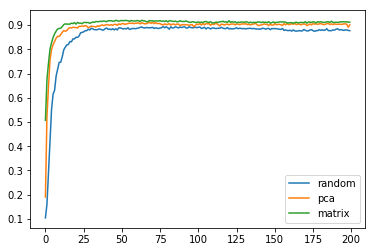

In [58]:
#plt.clear()
plt.plot(random[1], label = "random")
#plt.plot(random1[1], label = "random1")
plt.plot(pca[1], label = "pca")
plt.plot(svd[1], label = "matrix")
plt.legend(loc='lower right')
#plt.ylim([0.85, 1])
plt.show()

In [9]:
#import matplotlib.pyplot as plt
#
#from sklearn import datasets
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.preprocessing import MinMaxScaler
#iris = datasets.load_iris()
#
#X = X_test
#y = y_test
#
#slc = MinMaxScaler(feature_range=(-1, 1))
#pca = PCA(n_components=2)
#X_r = slc.fit_transform(pca.fit(X).transform(X))
#print(y.shape)
#lda = LinearDiscriminantAnalysis(n_components=2)
#X_r2 = slc.fit_transform(lda.fit(X, y).transform(X))
#
## Percentage of variance explained for each components
#print('explained variance ratio (first two components): %s'
#      % str(pca.explained_variance_ratio_))
#
#plt.figure()
#lw = 2
#
#for i in [0, 1, 2, 3,4,5,6,7,8,9]:
#    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, lw=lw,
#                label=target_name)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('PCA of IRIS dataset')
#
#plt.figure()
#for i in [0, 1, 2,3,4,5,6,7,8,9]:
#    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8,
#                label=target_name)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA of IRIS dataset')
#
#plt.show()

(1000,)
explained variance ratio (first two components): [ 0.11292753  0.08132449]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


NameError: name 'target_name' is not defined